# Lab 3

## Single Layer Neural Network, Evaluation, and Interpretation

This lab is designed to teach you about different strategies for evaluating neural networks and interpreting the results. For this lab, we are going to study different methods for intrepreting a neural network. We are going to use a modified version of the perceptron learning algorithm. I have modified it to use the sigmoid activation function. This means our learning rule is updated. 

**Note:** Exercises can be autograded and count towards your lab and assignment score. Problems are graded for participation.

In [1]:
from pathlib import Path 
home = str(Path.home()) # all other paths are relative to this path. change to something else if this is not the case on your system

In [2]:
%load_ext autoreload
%autoreload 2

# make sure your run the cell above before running this
import Lab3_helper

For developing this lab, we can use a Heart Disease factors dataset. Description of the data is found https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease.

In [3]:
import pandas as pd
heartdisease_df = pd.read_csv(
    f"{home}/csc-466-student/data/heart_disease.csv"
)
heartdisease_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,difficulty_walking_code,sex_code,age_category,race_code,diabetic_code,physical_activity_code,general_health_code,asthma_code,kidney_disease_code,skin_cancer_code
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,...,0,0,7,5,2,1,4,1,0,1
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,...,0,0,12,5,0,1,4,0,0,0
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,...,0,1,9,5,2,1,1,1,0,0
3,No,24.21,No,No,No,0,0,No,Female,75-79,...,0,0,11,5,0,0,2,0,0,1
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,...,1,0,4,5,0,1,4,0,0,0


We need to do some simple preprocessing before our neural network can deal with this data. 

In [4]:
X = heartdisease_df.drop(labels=["HeartDisease", "heart_disease"], axis=1)[:1000]
X = X.dropna()
X = pd.get_dummies(X)
X.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,smoking_code,alcohol_code,stroke_code,difficulty_walking_code,sex_code,age_category,...,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes
0,16.60,3,30,5,1,0,0,0,0,7,...,False,False,False,True,False,True,True,False,False,True
1,20.34,0,0,7,0,0,1,0,0,12,...,False,False,False,True,True,False,True,False,True,False
2,26.58,20,30,8,1,0,0,0,1,9,...,True,False,False,False,False,True,True,False,True,False
3,24.21,0,0,6,0,0,0,0,0,11,...,False,True,False,False,True,False,True,False,False,True
4,23.71,28,0,8,0,0,0,1,0,4,...,False,False,False,True,True,False,True,False,True,False


In [5]:
# Standard scaling
means = X.mean()
sds = X.std()
X2 = X.apply(lambda x: (x-means)/sds,axis=1)
X2

,BMI,PhysicalHealth,MentalHealth,SleepTime,smoking_code,alcohol_code,stroke_code,difficulty_walking_code,sex_code,age_category,...,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes
0,-1.902797,-0.178819,3.475697,-1.362385,1.172144,-0.178773,-0.310475,-0.615574,-0.704634,-0.908545,...,-0.474621,-0.730211,-0.290713,1.602765,-2.436904,2.436904,0.272102,-0.272102,-2.063709,2.063709
1,-1.334008,-0.509150,-0.431922,-0.147055,-0.852284,-0.178773,3.217650,-0.615574,-0.704634,1.150714,...,-0.474621,-0.730211,-0.290713,1.602765,0.409946,-0.409946,0.272102,-0.272102,0.484080,-0.484080
2,-0.385011,1.693056,3.475697,0.460610,1.172144,-0.178773,-0.310475,-0.615574,1.417757,-0.084842,...,2.104839,-0.730211,-0.290713,-0.623298,-2.436904,2.436904,0.272102,-0.272102,0.484080,-0.484080
3,-0.745447,-0.509150,-0.431922,-0.754720,-0.852284,-0.178773,-0.310475,-0.615574,-0.704634,0.738862,...,-0.474621,1.368097,-0.290713,-0.623298,0.409946,-0.409946,0.272102,-0.272102,-2.063709,2.063709
4,-0.821489,2.573939,-0.431922,0.460610,-0.852284,-0.178773,-0.310475,1.622876,-0.704634,-2.144101,...,-0.474621,-0.730211,-0.290713,1.602765,0.409946,-0.409946,0.272102,-0.272102,0.484080,-0.484080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.124950,0.591953,2.173157,0.460610,1.172144,-0.178773,-0.310475,-0.615574,-0.704634,-0.084842,...,2.104839,-0.730211,-0.290713,-0.623298,0.409946,-0.409946,0.272102,-0.272102,0.484080,-0.484080
996,-0.520365,-0.509150,-0.431922,0.460610,1.172144,-0.178773,-0.310475,-0.615574,-0.704634,0.738862,...,-0.474621,-0.730211,-0.290713,-0.623298,0.409946,-0.409946,0.272102,-0.272102,0.484080,-0.484080
997,-0.322657,-0.399040,-0.431922,0.460610,-0.852284,-0.178773,-0.310475,-0.615574,1.417757,0.327010,...,-0.474621,-0.730211,-0.290713,1.602765,0.409946,-0.409946,0.272102,-0.272102,0.484080,-0.484080
998,2.308374,2.794160,-0.431922,-0.754720,-0.852284,-0.178773,-0.310475,1.622876,-0.704634,0.327010,...,-0.474621,1.368097,-0.290713,-0.623298,-2.436904,2.436904,0.272102,-0.272102,0.484080,-0.484080


In [6]:
t = heartdisease_df.loc[X2.index,'heart_disease']
t.value_counts()

heart_disease
0    849
1    151
Name: count, dtype: int64

#### Problem 1
In your own words, describe the preprocessing steps I took above.

**Upload your solution/answer to Canvas.**

### Training the network
We are now going to train the network. We'll use the defaults that I've set in the function, but feel free to change them around and see how you can do. I am going to show you how setting the seed makes a difference in training the algorithm.

In [7]:
seeds = [0,1,2,3,4,5]
results = None
w = {}
X_test = {}
t_test = {}
for seed in seeds:
    w[seed],X_test[seed],t_test[seed],results1 = Lab3_helper.train(X2,t,seed=seed)
    if results is None:
        results = results1
    else:
        results = pd.concat([results,results1])

In [8]:
import altair as alt
alt.data_transformers.disable_max_rows()

source = results.reset_index().drop(['n','test_size','val_size'],axis=1).melt(id_vars=['epoch','seed'])

alt.Chart(source).mark_line().encode(
    x='epoch',
    y=alt.Y('value',title='Accuracy'),
    color='variable',
    column='seed'
)

alt.Chart(...)

#### Problem 2
Run a similar experiment but vary the learning rate as below. Keep the seed constant (seed=0). What do the graphs tell you about the parameter ``n`` (i.e., $\eta$)?

In [10]:
ns = [0.01,0.1]
results = None
#

**Upload your solution/answer to Canvas.**

In [11]:
source = results.reset_index().drop(['seed','test_size','val_size'],axis=1).melt(id_vars=['epoch','n'])

alt.Chart(source).mark_line().encode(
    x='epoch',
    y=alt.Y('value',title='Accuracy'),
    color='variable',
    column='n'
)

alt.Chart(...)

#### Exercise 1
The first step to evaluating any classification problem is establishing a baseline. Write a function that calculates the baseline accuracy if you predict the majority class on the test dataset.

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

seeds = [0,1,2,3,4,5]
results = []
columns=["accuracy_test","accuracy_train2","accuracy_val"]
#index_name.set_index("seed")
for seed in seeds:
    np.random.seed(seed)
    X_train, X_test, t_train, t_test = train_test_split(X2, t, test_size=0.3)
    X_train2, X_val, t_train2, t_val = train_test_split(X_train, t_train, test_size=0.3)

    ## Your solution in evaluate_baseline(...)
    accuracy_test,accuracy_train2,accuracy_val = Lab3_helper.evaluate_baseline(t_test,t_train2,t_val)
    
    results.append(pd.Series([accuracy_test,accuracy_train2,accuracy_val],index=columns,name=seed))

results = pd.concat(results,axis=1).T
results.index.name = "seed"
results

,accuracy_test,accuracy_train2,accuracy_val
seed,,,
0,0.826667,0.846939,0.885714
1,0.843333,0.844898,0.866667
2,0.856667,0.838776,0.861905
3,0.846667,0.834694,0.885714
4,0.850000,0.848980,0.847619
5,0.803333,0.857143,0.895238


Once you have done this, you will notice that the baseline accuracy is simply the fraction of the majority class in the dataset. For example:

In [13]:
frac_majority_class = t_test.value_counts(normalize=True)[0]
frac_majority_class

0.8033333333333333

Note how this is the same value as accuracy_test with ``seed=5``.

In [14]:
import altair as alt

source = results.melt()

alt.Chart(source).mark_boxplot().encode(
    x='variable:N',
    y=alt.Y('value:Q',scale=alt.Scale(domain=(0.7, 1)))
)

alt.Chart(...)

#### Exercise 2
Write a function that makes predictions for an X matrix using the weights.

In [15]:
w,X_test,t_test,results = Lab3_helper.train(X2,t,seed=0)

y_test = Lab3_helper.predict(w,X_test)
y_test

993    0
859    0
298    0
553    0
672    0
      ..
167    0
998    0
984    0
491    0
10     0
Length: 300, dtype: int64

In [16]:
y_test.value_counts()

0    242
1     58
Name: count, dtype: int64

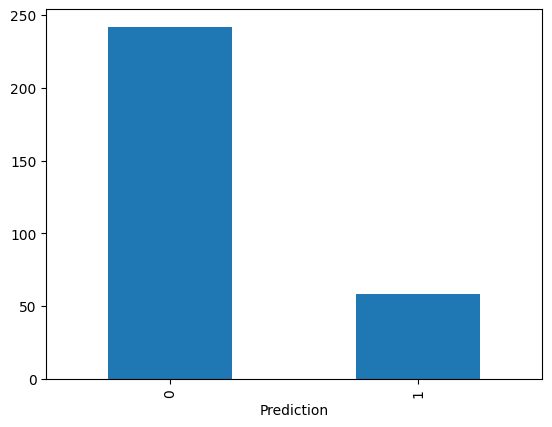

In [17]:
ax = y_test.value_counts().plot.bar()
ax.set_xlabel('Prediction');

#### Exercise 3
Write a function that calculates the confusion matrix.

In [18]:
y_test = Lab3_helper.predict(w,X_test)

cm = Lab3_helper.confusion_matrix(t_test,y_test,labels=[0,1])
cm

,0,1
0,212,36
1,30,22


#### Exercise 4
Sensitivity, recall, hit rate, or true positive rate (TPR)

${\displaystyle \mathrm {TPR} ={\frac {\mathrm {TP} }{\mathrm {P} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}=1-\mathrm {FNR} }$

specificity, selectivity or true negative rate (TNR)

${\displaystyle \mathrm {TNR} ={\frac {\mathrm {TN} }{\mathrm {N} }}={\frac {\mathrm {TN} }{\mathrm {TN} +\mathrm {FP} }}=1-\mathrm {FPR} }$

precision or positive predictive value (PPV)

${\displaystyle \mathrm {PPV} ={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FP} }}=1-\mathrm {FDR} }$

F1

${\displaystyle F_{1}={\frac {2}{\mathrm {recall^{-1}} +\mathrm {precision^{-1}} }}=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}={\frac {\mathrm {tp} }{\mathrm {tp} +{\frac {1}{2}}(\mathrm {fp} +\mathrm {fn} )}}}$

Write a function that calculates accuracy, sensitivity/recall, specificity, precision, and F1

In [19]:
stats = Lab3_helper.evaluation(cm,positive_class=1)
stats

{'accuracy': 0.78,
 'sensitivity/recall': 0.4230769230769231,
 'specificity': 0.8548387096774194,
 'precision': 0.3793103448275862,
 'F1': 0.4}

In [20]:
stats = Lab3_helper.evaluation(cm,positive_class=0)
stats

{'accuracy': 0.78,
 'sensitivity/recall': 0.8548387096774194,
 'specificity': 0.4230769230769231,
 'precision': 0.8760330578512396,
 'F1': 0.8653061224489798}

#### Exercise 5
Create a function that trains our neural network for each of the seeds and then returns variable importance of each feature as:

${\it importance}(w_i) = \frac{1}{|seeds|}\sum_{s \in seeds} \frac{\sqrt{w_i^2}}{max\left(\sqrt{w_0^2}, \sqrt{w_1^2} ... \sqrt{w_d^2}\right)}$

Basically, compute the variable importance for each seed and then average.

In [21]:
seeds = [0,1,2,3,4,5]
importances = Lab3_helper.importance(X2,t,seeds)
importances.sort_values(ascending=False)

Stroke_No               0.654807
Stroke_Yes              0.650848
stroke_code             0.643480
KidneyDisease_Yes       0.504048
GenHealth_Poor          0.503386
                          ...   
Race_Asian              0.031975
AgeCategory_35-39       0.030765
smoking_code            0.030713
AgeCategory_18-24       0.028640
PhysicalActivity_Yes    0.028193
Length: 63, dtype: float64

#### Problem 3: Compare these variable importances to the variable importances achieved by test-based permutation variable importance. 

To complete this problem, you will have to copy your previous lab's solutions to this notebook or Lab3_helper.py. From there, you can make the modifications necessary to train and evaluate the neural network instead of the Bayesian classifier.

In [22]:
#

Here is what I get when I run test based feature importance (you still need to do your own :))


stroke_code                        0.038111
Stroke_Yes                         0.036500
Stroke_No                          0.036111
KidneyDisease_Yes                  0.025167
GenHealth_Poor                     0.025000
                                     ...   
AgeCategory_30-34                 -0.000611
AgeCategory_35-39                 -0.000611
AgeCategory_50-54                 -0.000889
Diabetic_Yes (during pregnancy)   -0.001000
SkinCancer_No                     -0.001111
Length: 63, dtype: float64

**Upload your solution/answer to Canvas.**

In [26]:
# Good job!
# Don't forget to push with ./submit.sh

#### Having trouble with the test cases and the autograder?

You can always load up the answers for the autograder. The autograder runs your code and compares your answer to the expected answer. I manually review your code, so there is no need to hide this from you.

In [28]:
import joblib
answers = joblib.load(f"{home}/csc-466-student/tests/answers_Lab3.joblib")
answers.keys()

dict_keys(['exercise_1', 'exercise_2', 'exercise_3', 'exercise_4', 'exercise_5'])

In [ ]:
answers['exercise_2']